<a href="https://colab.research.google.com/github/TUIlmenauAMS/LowDelayMultichannelSourceSeparation_Random-Directions_Demo/blob/main/online_multichannel_source_separation_random_directions_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Low Latency Time Domain Multichannel Speech and Music Source Separation
### <center> Gerald Schuller,
### <center> Ilmenau University of Technology
### <center> Ilmenau, Germany

## <center> Goals
* Simple multichannel source separation with very low latency.
* Applications can be teleconferencing, hearing aids, augmented reality, or selective active noise cancellation.
* These real time applications need a very low latency, usually **less than about 6 ms**
* For that we need separation not just for speech, but **also music and noise**.


## <center> Previous Approaches
* Previous approaches usually use the frequency domain for separation, using the STFT
* Usually: STFT size of 4096, hop size of 2048 samples.
* The hop size alone leads to a algorithmic delay of 2047 samples.
* This is **128ms** at 16 kHz sampling rate, too much for our applications.
* Examples: FastMNMF, AuxIVA

## <center> Time Domain Approaches
* To obtain the least possible algorithmic delay, the time domain should be used instead.
* This uses time-domain unmixing filters
* Previous example: "Trinicon"
    (R. Aichner, H. Buchner, F. Yan, and W. Kellermann: A real-time blind source separation scheme and its application to reverberant and noisy acoustic environments, Signal Processing, 2006)

## <center> New Approach
* Uses the time domain
* The principle of a fractional delay and sum beamformer is used
* A fractional delay is implemented using an IIR filter (I. Senesnick,  “Low-pass  filters  realizable  as  all-pass sums: design via a new flat delay filter,” IEEE Transactions on Circuits and Systems II, 1999)
* This models the propagation delays of the sources between the microphones,
* together with an attenuation factor.
* Online processing is used (computing unmixing coefficients while processing audio)   




 ### <center> Unmixing Function

 * S: number of sources, M: number of microphones, $X_i(z)$: i-th microphone signal in the z-domain, $Y_i(z)$: i-th separated source, $a$: attenuations, $d$: fractional delays.
 \begin{align}
 \left[X_1(z),\ldots, X_M(z)\right] \cdot \begin{bmatrix}
      a_{1,1} z^{-d_{1,1}} & ...&a_{1,S} z^{-d_{1,S}} \\
      & \vdots &\\
      a_{M,1} z^{-d_{M,1}} & ...&a_{M,S} z^{-d_{M,S}}
      \end{bmatrix} =\left[Y_1(z),\ldots, Y_S(z)\right] \end{align}
* The attenuations $a$ abd fractional delays $d$ are the unmixing coefficients

### <center> The Objective Function
* The objective function for optimzation of the unmixing coefficients should be a measure of statistical independence between the separated sources
* Mutual information would measure it, but is complex to compute
* Instead, the **negative Kullback-Leibler divergence** between all pairs of separated sources is used
* The shown example has only one pair, which makes it even simpler.

* Since this represents a **very non-convex** objective function, a new approach for a **zeroth-order optimization method** is used.
* (G. Schuller, O. Golokolenko: "Probabilistic Optimization for Source Separation", Asilomar Conference on Signals, Systems, and Computers, 2020)

### <center> Optimization Pseudo Code
* Input: $f(·)$, $R^N→R$ : Objective function to be minimized;
 * $x_0$: Starting point vector (of the unmixing coefficients);
 * T: Number of optimization iterations;
 * P: Number of parallel processes;
 * startingscale: Standard deviation at the start;
 * endscale: Standard deviation at the end;
* Initialization: $x_{best}=x_0$
* for t= 1 to T do
 * scale=endscale+ (startingscale−endscale)·((1.0−t/iterations)^2)
 * Parallel Processing:
   * generate candidate update vectors $v_p$ with stddeviation ”scale” and zero mean on random subsets of coefficients;
 * $v_s= arg min_p f(x_{best}+v_p)$
 * if $f(x_{best}+v_s)< f(x{best})$ then:
   * $k_{best} = arg min_k {f(x_{best}+2^k·v_s)}$, k=(-8,...,8) (Line search)
   * $ x_{best}= x_{best}+ 2^{k_{best}}·v_s $
* return $x_{best}$

### <center> Low Latency Online Processing
* The optimization of suitable unmixing filters takes some signal time
* To avoid this causing a delay, it can be computed in a parallel thread, while already processing the signal in the time domain
* This means the separation in the beginning is not best, but improves quickly
* In this way an algorithmic delay in the order of the delays between the microphones is possible.


### <center> Pre-Processing
* The processing time for the unmixing coefficients increases with the signal length
* To reduce this time, the signal can be accumulated in a short signal block of about 0.5s length
* Assumption: The solution for the coefficients is not changed by the pre-processing.
* This is one of the novel contributions of the paper
* The is shown in the following code.
* In practice this is run contiuously, but the optimization is run, e.g., every few seconds for updating the unmixing coefficients.
* The demo below uses the "blockaccumlator" at the end of the demo file for the optimization of the unmixing coefficients


In [1]:
#Accumulate part of the signal in a signal "accumulator" of size "blocksize" (8000 samples, or 0.5s):
import numpy as np
blocksize=8000; blocks=10; blockaccumulator=np.zeros((blocksize,2)); X=np.zeros((blocks*blocksize,2)); blockno=0
for i in range(min(blocks,16)): #accumulate audio blocks over about 3 seconds:
    blockaccumulator=0.98*blockaccumulator + 0.02*X[blockno*blocksize+np.arange(blocksize)]
    blockno+=1

## <center> Comparison, Evaluation
* A comparison method is "Trinicon", with implementation of the "pyroomacoustics" Python module.
* For a more precise comparison, the same parallel processing was applied
* For both, the first ca. 8 seconds of the signal were used to obtain the optimized filter coefficients
* These filter coefficients where then used to unmix the entire signal

* Further, non-online frequency domain methods for comparison (implementations from pyroomacoustics):
  * Fast MNMF
  * AuxIVA

### <center> Used Audio Sources

Pairs from speech, and also noise, and music (all 16 kHz sampling rate):
* Synthetic male speech from "espeak" (http://espeak.sourceforge.net/)
* Synthetic female speech from espeak
* Pink noise from "csound" (https://github.com/csound/csound) ('pinkish16.wav')
* Tones from "csound" ("oscili")
* Music ("fantasy-orchestra") from https://freesound.org
* The pairs are: (('espeakfemale_16.wav', 'espeakwav_16.wav'),('pinkish16.wav', 'espeakwav_16.wav'), ('oscili_test_16.wav', 'espeakwav_16.wav'),('fantasy-orchestra_m16.wav', 'espeakwav_16.wav'))

### <center> Microphone Setups

3 microphone setups where testet:
*  A stereo microphone pair, 20cm apart
*  A square of 4 microphones, 20cm side length
*  A cube of 8 microphones, 20cm side length

### <center> Simulated Room



Dots: sources, crosses: microphones
rt60= 0.1
e_absorption= 0.9477283867579678 max_order = 16


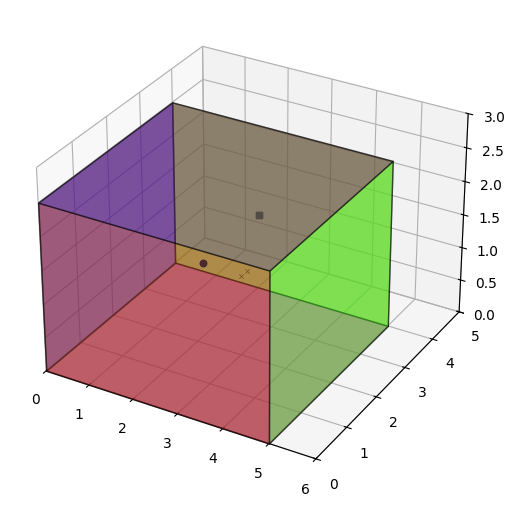

wrote to mix16000.wav


In [2]:
#!git clone https://github.com/TUIlmenauAMS/LowDelayMultichannelSourceSeparation_Random-Directions_Demo
#!mv ./LowDelayMultichannelSourceSeparation_Random-Directions_Demo/* .
#!rm -r ./LowDelayMultichannelSourceSeparation_Random-Directions_Demo
#!pip install pyroomacoustics > /dev/null
from simple_room_mix import room_mix
print("Dots: sources, crosses: microphones")
mixfile="mix16000.wav" #output file from function room_mix, can be replaced by own mix with different name
files=('pinkish16.wav', 'espeakwav_16.wav') #Can be replaced by other pairs own source files
room_mix(files, micsetup='stereo', plot=True, rt60=0.1) #can be "stereo", "square", or "cube"

## <center> Evaluation
* As evaluation, the Python module "mir_eval" was used
 * (Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, “mir_eval: A Transparent Implementation of Common MIR Metrics”, Proceedings of the 15th International Conference on Music Information Retrieval, 2014.)
* It computes the
  * "Signal to Distortion Ratio" (**SDR**, linear distortions, like filtering)
  * "Signal to Interference Ratio" (**SIR**)
  * "Signal to Artifacts Ratio" (**SAR**, non-linear distorions)
* These measures are averaged over the different source pairs, and the standard deviation is computed.

* Here most interesting:
  * The **SIR** for separation performance
  * The **SAR**, because it represents non-linear distortions, at which the presented algorithm should be particularly good at.

### <center> Main results
* Between the 2 online algorithms, the best **SIR** (separation) is achived by the presented **Random Directions** method, with 9 dB for the stereo case
* The best **overall SAR** (non-lin. distortions) is achieved also with the **Random Directions**, with 33 dB for the stereo case
* The best overall SIR, including offline methods, is achieved by FastMNMF with 20 dB for the stereo case.
* Due to its stochastic nature, **Random Directions** also has the **highest standard deviations**.
* It still works for more microphones (square, cubic), but declines somewhat in separation performance, but not as much as Trinicon.
* The following table shows the results (mean and standard deviation) for the above pairs
* Because of the stochastic nature of the presented Random Directions optimizer, each signal pair was presented 10 times to it, to obtain more precise results.

In [3]:
import pandas as pd
data = pd.read_csv('meanstd.csv')
datamethod=data.set_index('method')
#print("ordered by method:\n", datamethod)
print("ordered by method:\n", datamethod.loc[:,['Unnamed: 0','SIR', 'SAR', 'Proc.Time','micsetup']])

ordered by method:
                Unnamed: 0        SIR        SAR  Proc.Time micsetup
method                                                             
randdironline        mean   9.369865  33.016048   2.826782   stereo
randdironline    std.dev.   4.705160   8.468150   0.161924   stereo
randdironline        mean   8.029211  31.284094   3.322401   square
randdironline    std.dev.   5.480382   6.603044   0.154208   square
randdironline        mean   4.219051  30.210056   4.571869     cube
randdironline    std.dev.   3.442526   5.827543   0.180234     cube
trinicononline       mean   3.383970  18.839343   1.123047   stereo
trinicononline   std.dev.   1.020178   4.584592   0.019606   stereo
trinicononline       mean   0.981095  18.055771   2.029732   square
trinicononline   std.dev.   0.364861   1.429649   0.012473   square
trinicononline       mean   1.042075  19.991405   3.867704     cube
trinicononline   std.dev.   0.626075   3.517759   0.034936     cube
fastmnmf             mean  2

## <center> Audio Examples
* The audio examples below use the pair ('pinkish16.wav', 'espeakwav_16.wav')
* Here you can listen to the mixed file
* unmix it with the different methods, and listen to the results.
* Listening is important because the listening experince often differs from objective measures.

In [4]:
from IPython.display import Audio
print("Two-channel microphone signal mix created above:")
#mixfile="mix16000.wav"
display(Audio(mixfile))

Two-channel microphone signal mix created above:


### <center> The Method of Random Directions
* Try a few times to see how the result might change
* Objective function X0 around -2 means good separation.

In [5]:
from importlib import reload
import ICAabskl_puredelay_multichan_randdir_online as randdir
#randdir = reload(randdir)
processingtime, X_sep = randdir.separation_randdir(mixfile, plot=False)

X.shape= (115836, 2)
Number of channels N: 2
coeffs= [[0.73157101 0.37646086]
 [0.17683482 0.02625608]
 [0.55637903 0.69934466]
 [0.37949364 0.86803538]]
siglen= 115836
blocks= 14
coeffdeviation= 1.0
coeffdeviation=ones
num of CPU's or parallelset: 16
Number of parallel processes, parallelset=  16
endscale= 0.0
m= 0 setfrac= 1.5 scale= 4.0
lineexp= -1 X1= -1.0634857251530185
coeffdeviation= [[0.96077253 0.94886161]
 [0.90822261 1.14106768]
 [1.01318646 0.92472235]
 [0.9157307  0.94547721]]
Obj. function X0= -1.0634857251530185 iteration m= 1 scale= 4.0 magvar.= 5.179189148896245
coeffdeviation= [[1.01763007 0.85427218]
 [0.98708362 1.14489437]
 [1.0046989  0.89775687]
 [0.83243131 0.88147337]]
Obj. function X0= -1.0660424808917164 iteration m= 16 scale= 3.873024 magvar.= 2.1783179354841784
lineexp= 1 X1= -1.2506688749541526
lineexp= 2 X1= -1.3246250212521087
coeffdeviation= [[1.02014552 0.84374224]
 [0.92147144 1.13813074]
 [0.94375412 0.87616487]
 [0.77014852 1.00348213]]
Obj. functio

In [6]:
print("Separated Source 0:"); display(Audio(32000*X_sep[:,0], rate=16000));
print("Separated Source 1:"); display(Audio(32000*X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


### <center> The Trinicon Method

In [7]:
import trinicon_online_bss as trinicon
#mixfile="mix16000.wav"
processingtime, X_sep = trinicon.separation_trinicon(mixfile, plot=False)
#sepchanfile='sepchan_trinicon_online.wav' #wav.write inside function

X.shape= (115838, 2)
X_sep.shape= (2, 8510) demixmat.shape= (2, 2, 512)
Duration of optimization: 1.3473663330078125 sec.
coeffs.shape= (2, 2, 512)
Duration of unmixing: 0.0537872314453125 sec.
np.max(X_sep)= 0.7922592078085843
Written to sepchan_trinicon_online.wav, play with: play sepchan_trinicon_online.wav remix 1/2


In [8]:
print("Separated Source 0:"); display(Audio(32000*X_sep[:,0], rate=16000));
print("Separated Source 1:"); display(Audio(32000*X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


### The unmixed sources from the offline method FastMNMF:

In [11]:
import fastmnmf_bss as fastmnmf
#mixfile="mix16000.wav"
processingtime, X_sep = fastmnmf.separation_fastmnmf(mixfile, plot=False)

X.shape= (115838, 2)
X_sep.shape= (114688, 2)
Duration of optimization: 4.8868067264556885 sec.
Written to sepchan_fastmnmf.wav, play with: play sepchan_fastmnmf.wav remix 1/2


In [12]:
print("Separated Source 0:"); display(Audio(32000*X_sep[:,0], rate=16000));
print("Separated Source 1:"); display(Audio(32000*X_sep[:,1], rate=16000))

Separated Source 0:


Separated Source 1:


## <center> Conclusions
* The method of Random Directions can successfully optimize the very non-convex objective function for separation in the time domain
* It also works for non-speech signals and more microphones
* It can be used for real time online applications
* It compares favourably to Trinicon in terms of SIR (the separation performance 9 vs. 3 dB for the 2 microphone case) and SAR (the non-linear distortions, 33 vs. 18 dB)
* It compares favourably in terms of SAR  to FastMNMF (33 vs. 14 dB), but not in terms of SIR (9 vs. 20 dB, the price to pay for low delay online processing).
* But it has a higher standard deviation, meaning the separation results vary more.